In [2]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "svg"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

## 2D model

In [ ]:
class Swarmalators2D():
    def __init__(self, agentsNum: int, dt: float, K: float) -> None:
        np.random.seed(randomSeed)
        self.positionX = np.random.random((agentsNum, 2)) * 2 - 1
        self.phaseTheta = np.random.random(agentsNum) * 2 * np.pi
        self.agentsNum = agentsNum
        self.dt = dt
        self.K = K

    @staticmethod
    @nb.njit
    def _delta_theta(phaseTheta):
        dim = phaseTheta.shape[0]
        subTheta = phaseTheta - np.repeat(phaseTheta, dim).reshape(dim, dim)

        deltaTheta = np.zeros((dim, dim - 1))
        for i in np.arange(dim):
            deltaTheta[i, :i], deltaTheta[i, i:] = subTheta[i, :i], subTheta[i, i + 1 :]
        return deltaTheta

    @staticmethod
    @nb.njit
    def _delta_x(positionX):
        dim = positionX.shape[0]
        subX = positionX - np.repeat(positionX, dim).reshape(dim, 2, dim).transpose(0, 2, 1)
        deltaX = np.zeros((dim, dim - 1, 2))
        for i in np.arange(dim):
            deltaX[i, :i], deltaX[i, i:] = subX[i, :i], subX[i, i + 1 :]
        return deltaX

    @staticmethod
    @nb.njit
    def distance_x_2(deltaX):
        return np.sqrt(deltaX[:, :, 0] ** 2 + deltaX[:, :, 1] ** 2).reshape(deltaX.shape[0], deltaX.shape[1], 1)

    @staticmethod
    @nb.njit
    def distance_x(deltaX):
        return np.sqrt(deltaX[:, :, 0] ** 2 + deltaX[:, :, 1] ** 2)

    @property
    def deltaTheta(self) -> np.ndarray:
        """Phase difference between agents"""
        return self._delta_theta(self.phaseTheta)

    @property
    def deltaX(self) -> np.ndarray:
        """Spatial difference between agents"""
        return self._delta_x(self.positionX)

    @property
    def Fatt(self) -> np.ndarray:
        """Effect of phase similarity on spatial attraction"""
        pass

    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion"""
        pass

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction"""
        pass

    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion"""
        pass

    @property
    def H(self) -> np.ndarray:
        """Phase interaction"""
        pass

    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings"""
        pass

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity"""
        pass

    @property
    def omega(self) -> np.ndarray:
        """Natural intrinsic frequency"""
        pass

    @staticmethod
    @nb.njit
    def _update(
        positionX: np.ndarray, phaseTheta: np.ndarray,
        velocity: np.ndarray, omega: np.ndarray,
        Iatt: np.ndarray, Irep: np.ndarray,
        Fatt: np.ndarray, Frep: np.ndarray,
        H: np.ndarray, G: np.ndarray,
        K: float, dt: float
    ):
        dim = positionX.shape[0]
        pointX = velocity + np.sum(
            Iatt * Fatt.reshape((dim, dim - 1, 1)) - Irep * Frep.reshape((dim, dim - 1, 1)),
            axis=1
        ) / (dim - 1)
        positionX += pointX * dt
        pointTheta = omega + K * np.sum(H * G, axis=1) / (dim - 1)
        phaseTheta = np.mod(phaseTheta + pointTheta * dt, 2 * np.pi)
        return positionX, phaseTheta
    

    def update(self) -> None:
        self.positionX, self.phaseTheta = self._update(
            self.positionX, self.phaseTheta,
            self.velocity, self.omega,
            self.Iatt, self.Irep,
            self.Fatt, self.Frep,
            self.H, self.G,
            self.K, self.dt
        )

    def plot(self) -> None:
        plt.figure(figsize=(6, 5))

        plt.scatter(self.positionX[:, 0], self.positionX[:, 1],
                    c=self.phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi)

        cbar = plt.colorbar(ticks=[0, np.pi, 2*np.pi])
        cbar.ax.set_ylim(0, 2*np.pi)
        cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
        
        # plt.show()


class ChiralSwarmalators2D(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float,
                 J: float, K: float,
                 A: float, B: float) -> None:
        super().__init__(agentsNum, dt, K)
        self.J = J
        self.K = K
        self.A = A
        self.B = B * np.ones((agentsNum, agentsNum - 1))
        self.omegaValue = np.ones(agentsNum)
        randomHalfIdx = np.random.choice(agentsNum, agentsNum // 2, replace=False)
        self.omegaValue[randomHalfIdx] = -1

    @property
    def omega(self) -> np.ndarray:
        return self.omegaValue

    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction
        A + J * cos(theta_j - theta_i)
        """
        return self.A + self.J * np.cos(self.deltaTheta)
    
    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: B"""
        return self.B

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: (x_j - x_i) / |x_j - x_i|"""

        return self.deltaX / self.distance_x_2(self.deltaX)
    # self.deltaX / np.linalg.norm(self.deltaX, axis=-1, keepdims=True)
    
    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i| ^ 2"""
        return self.deltaX / self.distance_x_2(self.deltaX) ** 2

    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta)
    
    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings: 1 / |x_i - x_j|"""
        return 1 / self.distance_x(self.deltaX)
    
    @staticmethod
    @nb.njit
    def _velocity(omega: np.ndarray, phaseTheta: np.ndarray) -> np.ndarray:
        dim = omega.shape[0]
        n = np.zeros((dim, 2))
        n[:, 0] = np.cos(phaseTheta + np.pi / 2)
        n[:, 1] = np.sin(phaseTheta + np.pi / 2)
        return np.sign(omega).reshape((dim, 1)) * n

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return self._velocity(self.omega, self.phaseTheta)
    
class FreqCoupledChiralSwarmalators2D(ChiralSwarmalators2D):
    def __init__(self, agentsNum: int, dt: float,
                 J: float, K: float,
                 A: float, B: float) -> None:
        super().__init__(agentsNum, dt, J, K, A, B)
        self.QdotX = np.pi / 2 * self.delta_sign_omega(self.omegaValue)
        self.QdotTheta = np.pi / 4 * self.delta_sign_omega(self.omegaValue)

    @staticmethod
    @nb.njit
    def delta_sign_omega(omega: np.ndarray):
        dim = omega.shape[0]
        subOmega = np.sign(omega) - np.sign(np.repeat(omega, dim).reshape(dim, dim))

        deltaOmega = np.zeros((dim, dim - 1))
        for i in np.arange(dim):
            deltaOmega[i, :i], deltaOmega[i, i:] = subOmega[i, :i], subOmega[i, i + 1 :]
        return np.abs(deltaOmega)
    
    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction
        A + J * cos(theta_j - theta_i)
        """
        return self.A + self.J * np.cos(self.deltaTheta - self.QdotX)
    
    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta - self.QdotTheta)

def plot_2d_model(positionX, phaseTheta, velocity, xlim, ylim, title):
    plt.figure(figsize=(6, 5))

    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'

    
    
    plt.quiver(positionX[:, 0], positionX[:, 1], velocity[:, 0], velocity[:, 1],
               color=[new_cmap(i) for i in colors_idx(phaseTheta)], alpha=0.8, scale=15, width=0.005)
    plt.scatter(positionX[:, 0], positionX[:, 1],
                c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi, s=0.1)
    cbar = plt.colorbar(ticks=[0, np.pi, 2 * np.pi])
    cbar.ax.set_ylim(0, 2* np.pi)
    cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)

## RevolvingSwarmalators

In [ ]:
JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)
dt = 0.1

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    model = ChiralSwarmalators2D(agentsNum=500, dt=dt, J=J, K=K, A=1, B=1)

    if os.path.exists("images"):
        shutil.rmtree("images")
    os.mkdir("images")

    positions = []
    phases = []
    velocities = []

    for i in tqdm(range(1000)):
        model.update()
        if i % 5 == 0:
            positions.append(model.positionX.copy())
            phases.append(model.phaseTheta.copy())
            velocities.append(model.velocity.copy())

    xOfPositions = np.array(positions)[:, :, 0]
    yOfPositions = np.array(positions)[:, :, 1]
    xlim = (np.min(xOfPositions), np.max(xOfPositions))
    ylim = (np.min(yOfPositions), np.max(yOfPositions))
    images = []

    for i, (position, phase, velocity) in tqdm(enumerate(zip(positions, phases, velocities)), total=len(positions)):
        plot_2d_model(position, phase, velocity, xlim=xlim, ylim=ylim, title=f"{i}. J={J}, K={K}, t={dt * 5 * i}")
        plt.savefig(f"images/{i}.png")
        plt.close()
        images.append(imageio.imread(f"images/{i}.png"))
        
    imageio.mimsave(f"./RevolvingSwarmalators/J={J}_K={K}.gif", images, fps=10)

## FreqCoupled

In [ ]:
from itertools import product
JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)
dt = 0.1

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    model = FreqCoupledChiralSwarmalators2D(agentsNum=500, dt=dt, J=J, K=K, A=1, B=1)

    if os.path.exists("imagesFreqCoupled"):
        shutil.rmtree("imagesFreqCoupled")
    os.mkdir("imagesFreqCoupled")

    positions = []
    phases = []
    velocities = []

    for i in tqdm(range(1000)):
        model.update()
        if i % 5 == 0:
            positions.append(model.positionX.copy())
            phases.append(model.phaseTheta.copy())
            velocities.append(model.velocity.copy())

    xOfPositions = np.array(positions)[:, :, 0]
    yOfPositions = np.array(positions)[:, :, 1]
    xlim = (np.min(xOfPositions), np.max(xOfPositions))
    ylim = (np.min(yOfPositions), np.max(yOfPositions))
    images = []

    for i, (position, phase, velocity) in tqdm(enumerate(zip(positions, phases, velocities)), total=len(positions)):
        plot_2d_model(position, phase, velocity, xlim=xlim, ylim=ylim, title=f"{i}. J={J}, K={K}, t={dt * 5 * i}")
        plt.savefig(f"imagesFreqCoupled/{i}.png")
        plt.close()
        images.append(imageio.imread(f"imagesFreqCoupled/{i}.png"))
        
    imageio.mimsave(f"./FreqCoupled/FreqCoupledJ={J}_K={K}.gif", images, fps=10)

## vstack

In [ ]:
import os

JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    input1 = f"RevolvingSwarmalators\J={J}_K={K}.gif"
    input2 = f"FreqCoupled\FreqCoupledJ={J}_K={K}.gif"
    output = f"vstack\J={J}_K={K}.mp4"

    if os.path.exists(output):
        os.remove(output)

    os.system(f"ffmpeg -i {input1} -i {input2} -filter_complex vstack -qscale:v 100 {output}")

## 3D model

In [20]:
class Swarmalators3D():
    def __init__(self, agentsNum: int, dt: float, K: float) -> None:
        np.random.seed(randomSeed)
        self.positionX = np.random.random((agentsNum, 3)) * 2 - 1
        self.phaseTheta = np.random.random(agentsNum) * 2 * np.pi
        self.agentsNum = agentsNum
        self.dt = dt
        self.K = K

    @staticmethod
    @nb.njit
    def _delta_theta(phaseTheta):
        dim = phaseTheta.shape[0]
        subTheta = phaseTheta - np.repeat(phaseTheta, dim).reshape(dim, dim)

        deltaTheta = np.zeros((dim, dim - 1))
        for i in np.arange(dim):
            deltaTheta[i, :i], deltaTheta[i,
                                          i:] = subTheta[i, :i], subTheta[i, i + 1:]
        return deltaTheta

    @property
    def deltaTheta(self) -> np.ndarray:
        """Phase difference between agents"""
        return self._delta_theta(self.phaseTheta)

    @staticmethod
    @nb.njit
    def _delta_x(positionX):
        dim = positionX.shape[0]
        subX = positionX - \
            np.repeat(positionX, dim).reshape(dim, 3, dim).transpose(0, 2, 1)
        deltaX = np.zeros((dim, dim - 1, 3))
        for i in np.arange(dim):
            deltaX[i, :i], deltaX[i, i:] = subX[i, :i], subX[i, i + 1:]
        return deltaX

    @property
    def deltaX(self) -> np.ndarray:
        """Spatial difference between agents"""
        return self._delta_x(self.positionX)

    @property
    def Fatt(self) -> np.ndarray:
        """Effect of phase similarity on spatial attraction"""
        pass

    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion"""
        pass

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction"""
        pass

    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion"""
        pass

    @property
    def H(self) -> np.ndarray:
        """Phase interaction"""
        pass

    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings"""
        pass

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity"""
        pass

    @property
    def omega(self) -> np.ndarray:
        """Natural intrinsic frequency"""
        pass

    @staticmethod
    @nb.njit
    def distance_x(deltaX):
        return np.sqrt(
            deltaX[:, :, 0] ** 2 + deltaX[:, :, 1] ** 2 + deltaX[:, :, 2] ** 2
        )

    @staticmethod
    @nb.njit
    def distance_x_2(deltaX):
        return np.sqrt(
            deltaX[:, :, 0] ** 2 + deltaX[:, :, 1] ** 2 + deltaX[:, :, 2] ** 2
        ).reshape(deltaX.shape[0], deltaX.shape[1], 1)

    @staticmethod
    @nb.njit
    def _update(
        positionX: np.ndarray, phaseTheta: np.ndarray,
        velocity: np.ndarray, omega: np.ndarray,
        Iatt: np.ndarray, Irep: np.ndarray,
        Fatt: np.ndarray, Frep: np.ndarray,
        H: np.ndarray, G: np.ndarray,
        K: float, dt: float
    ):
        dim = positionX.shape[0]
        pointX = velocity + np.sum(
            Iatt * Fatt.reshape((dim, dim - 1, 1)) - Irep *
            Frep.reshape((dim, dim - 1, 1)),
            axis=1
        ) / (dim - 1)
        positionX += pointX * dt
        pointTheta = omega + K * np.sum(H * G, axis=1) / (dim - 1)
        phaseTheta = np.mod(phaseTheta + pointTheta * dt, 2 * np.pi)
        return positionX, phaseTheta

    def update(self) -> None:
        self.positionX, self.phaseTheta = self._update(
            self.positionX, self.phaseTheta,
            self.velocity, self.omega,
            self.Iatt, self.Irep,
            self.Fatt, self.Frep,
            self.H, self.G,
            self.K, self.dt
        )


class ChiralSwarmalators3D(Swarmalators3D):
    def __init__(self, agentsNum: int, dt: float,
                 J: float, K: float,
                 A: float, B: float) -> None:
        super().__init__(agentsNum, dt, K)
        self.J = J
        self.K = K
        self.A = A
        self.B = B * np.ones((agentsNum, agentsNum - 1))
        self.omegaValue = np.ones(agentsNum)
        randomHalfIdx = np.random.choice(
            agentsNum, agentsNum // 2, replace=False)
        self.omegaValue[randomHalfIdx] = -1

    @property
    def omega(self) -> np.ndarray:
        return self.omegaValue

    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction
        A + J * cos(theta_j - theta_i)
        """
        return self.A + self.J * np.cos(self.deltaTheta)

    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: B"""
        return self.B

    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: (x_j - x_i) / |x_j - x_i|"""

        return self.deltaX / self.distance_x_2(self.deltaX)
    # self.deltaX / np.linalg.norm(self.deltaX, axis=-1, keepdims=True)

    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i| ^ 2"""
        return self.deltaX / self.distance_x_2(self.deltaX) ** 2

    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta)

    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings: 1 / |x_i - x_j|"""
        return 1 / self.distance_x(self.deltaX)

    @staticmethod
    @nb.njit
    def _velocity(omega: np.ndarray, phaseTheta: np.ndarray) -> np.ndarray:
        dim = omega.shape[0]
        n = np.zeros((dim, 3))
        omegaSign = np.sign(omega)
        n[:, 0] = np.cos(phaseTheta + np.pi / 2) * omegaSign
        n[:, 1] = np.sin(phaseTheta + np.pi / 2) * omegaSign
        n[:, 2] = np.cos(phaseTheta) * (omegaSign == 1) + \
            np.sin(phaseTheta) * (omegaSign == -1)
        return n

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return self._velocity(self.omega, self.phaseTheta)


class ChiralSwarmalators3DUrand(ChiralSwarmalators3D):
    def __init__(self, agentsNum: int, dt: float,
                 J: float, K: float,
                 A: float, B: float) -> None:
        super().__init__(agentsNum, dt, J, K, A, B)
        self.zi = np.random.random(agentsNum)

    @staticmethod
    @nb.njit
    def _velocity(omega: np.ndarray, phaseTheta: np.ndarray, zi: np.ndarray) -> np.ndarray:
        dim = omega.shape[0]
        n = np.zeros((dim, 3))
        omegaSign = np.sign(omega)
        n[:, 0] = np.cos(phaseTheta + np.pi / 2) * omegaSign
        n[:, 1] = np.sin(phaseTheta + np.pi / 2) * omegaSign
        n[:, 2] = zi
        return n

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return self._velocity(self.omega, self.phaseTheta, self.zi)


class FreqCoupledChiralSwarmalators3D(ChiralSwarmalators3D):
    def __init__(self, agentsNum: int, dt: float,
                 J: float, K: float,
                 A: float, B: float) -> None:
        super().__init__(agentsNum, dt, J, K, A, B)
        self.QdotX = np.pi / 2 * self.delta_sign_omega(self.omegaValue)
        self.QdotTheta = np.pi / 4 * self.delta_sign_omega(self.omegaValue)

    @staticmethod
    @nb.njit
    def delta_sign_omega(omega: np.ndarray):
        dim = omega.shape[0]
        subOmega = np.sign(omega) - \
            np.sign(np.repeat(omega, dim).reshape(dim, dim))

        deltaOmega = np.zeros((dim, dim - 1))
        for i in np.arange(dim):
            deltaOmega[i, :i], deltaOmega[i,
                                          i:] = subOmega[i, :i], subOmega[i, i + 1:]
        return np.abs(deltaOmega)

    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction
        A + J * cos(theta_j - theta_i)
        """
        return self.A + self.J * np.cos(self.deltaTheta - self.QdotX)

    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta - self.QdotTheta)


class FreqCoupledChiralSwarmalators3DUrand(FreqCoupledChiralSwarmalators3D):
    def __init__(self, agentsNum: int, dt: float,
                 J: float, K: float,
                 A: float, B: float) -> None:
        super().__init__(agentsNum, dt, J, K, A, B)
        self.zi = np.random.random(agentsNum)

    @staticmethod
    @nb.njit
    def _velocity(omega: np.ndarray, phaseTheta: np.ndarray, zi: np.ndarray) -> np.ndarray:
        dim = omega.shape[0]
        n = np.zeros((dim, 3))
        omegaSign = np.sign(omega)
        n[:, 0] = np.cos(phaseTheta + np.pi / 2) * omegaSign
        n[:, 1] = np.sin(phaseTheta + np.pi / 2) * omegaSign
        n[:, 2] = zi
        return n

    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return self._velocity(self.omega, self.phaseTheta, self.zi)


def plot_3d_model(positionX, phaseTheta, velocity, xlim, ylim, zlim, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 画3D向量，以positionX为起点，以velocity为方向，颜色为相位，保持箭头和剑身颜色一致
    colors = [[new_cmap(i)] * 3 for i in colors_idx(phaseTheta)]
    for i in range(len(colors)):
        ax.quiver(positionX[i, 0], positionX[i, 1], positionX[i, 2],
                  velocity[i, 0], velocity[i, 1], velocity[i, 2],
                  colors=colors[i],
                  alpha=0.8, length=0.25, arrow_length_ratio=0.5, linewidths=2)
    scatter = ax.scatter(positionX[:, 0], positionX[:, 1], positionX[:, 2],
                         c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi, s=0.01)
    centroid = np.mean(positionX, axis=0)
    centroidVelocity = np.mean(velocity, axis=0)
    ax.quiver(centroid[0], centroid[1], centroid[2],
              centroidVelocity[0], centroidVelocity[1], centroidVelocity[2],
              color='black', alpha=1, length=0.25, arrow_length_ratio=0.5, linewidths=5)
    cbar = plt.colorbar(scatter, ticks=[0, np.pi, 2*np.pi])
    cbar.ax.set_ylim(0, 2*np.pi)
    cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title(title)


def plot_3d_model_multi_clsuters(positionX, phaseTheta, velocity, xlim, ylim, zlim, title, omega):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 画3D向量，以positionX为起点，以velocity为方向，颜色为相位，保持箭头和剑身颜色一致
    colors = [[new_cmap(i)] * 3 for i in colors_idx(phaseTheta)]
    for i in range(len(colors)):
        ax.quiver(positionX[i, 0], positionX[i, 1], positionX[i, 2],
                  velocity[i, 0], velocity[i, 1], velocity[i, 2],
                  colors=colors[i],
                  alpha=0.8, length=0.25, arrow_length_ratio=0.5, linewidths=2)
    scatter = ax.scatter(positionX[:, 0], positionX[:, 1], positionX[:, 2],
                         c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi, s=0.01)
    for omegaCluster in np.unique(omega):
        centroid = np.mean(positionX[omega == omegaCluster], axis=0)
        centroidVelocity = np.mean(velocity[omega == omegaCluster], axis=0)
        ax.quiver(
            centroid[0], centroid[1], centroid[2],
            centroidVelocity[0], centroidVelocity[1], centroidVelocity[2],
            color='black', alpha=1, length=2, arrow_length_ratio=0.5, linewidths=5, normalize=True)
    cbar = plt.colorbar(scatter, ticks=[0, np.pi, 2*np.pi])
    cbar.ax.set_ylim(0, 2*np.pi)
    cbar.ax.set_yticklabels(['$0$', '$\pi$', '$2\pi$'])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    ax.set_title(title)


In [21]:
model = ChiralSwarmalators3D(agentsNum=500, dt=0.1, J=1, K=-0.5, A=1, B=1)

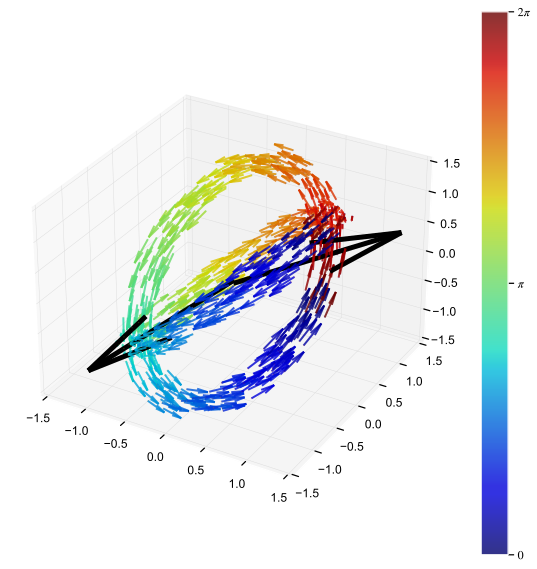

In [26]:
# for i in range(100):
model.update()

plot_3d_model_multi_clsuters(
    model.positionX, model.phaseTheta, model.velocity, 
    xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), zlim=(-1.5, 1.5), title="", omega=model.omega
)

In [8]:
model.omegaValue

array([ 1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
       -1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1., -1., -1.,  1., -1., -1.,  1., -1., -1.,  1., -1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
        1.,  1., -1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
       -1., -1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
       -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,
       -1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1., -1., -1., -1

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

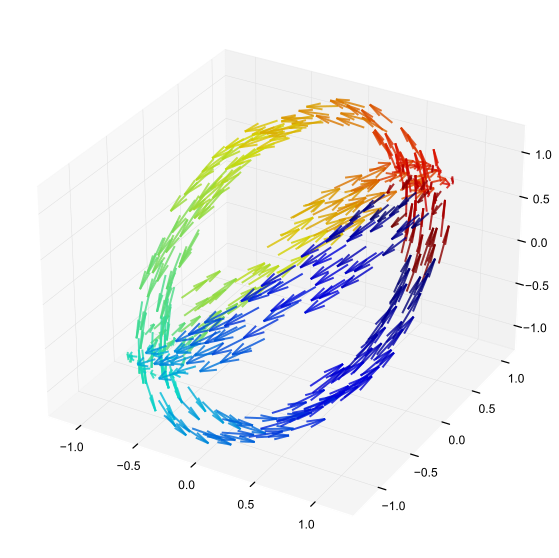

In [6]:
if os.path.exists("3DinvolveImages"):
    shutil.rmtree("3DinvolveImages")
os.mkdir("3DinvolveImages")

positions = []
phases = []
velocities = []

for i in tqdm(range(1000)):
    model.update()
    if i % 5 == 0:
        positions.append(model.positionX.copy())
        phases.append(model.phaseTheta.copy())
        velocities.append(model.velocity.copy())

xOfPositions = np.array(positions)[:, :, 0]
yOfPositions = np.array(positions)[:, :, 1]
zOfPositions = np.array(positions)[:, :, 2]
xlim = (np.min(xOfPositions), np.max(xOfPositions))
ylim = (np.min(yOfPositions), np.max(yOfPositions))
zlim = (np.min(zOfPositions), np.max(zOfPositions))
images = []

for i, (position, phase, velocity) in tqdm(enumerate(zip(positions, phases, velocities)), total=len(positions)):
    plot_3d_model(position, phase, velocity, xlim=xlim, ylim=ylim, zlim=zlim, title=f"{i}. J=1, K=-0.5, t={0.5 * i}")
    plt.savefig(f"3DinvolveImages/{i}.png")
    plt.close()
    images.append(imageio.imread(f"3DinvolveImages/{i}.png"))

imageio.mimsave(f"./3Dinvolve.gif", images, fps=10)

In [ ]:
JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)
dt = 0.1

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    model = ChiralSwarmalators3D(agentsNum=500, dt=dt, J=J, K=K, A=1, B=1)

    if os.path.exists("images"):
        shutil.rmtree("images")
    os.mkdir("images")

    positions = []
    phases = []
    velocities = []

    for i in tqdm(range(1000), desc=f"J={J}, K={K}"):
        model.update()
        if i % 5 == 0:
            positions.append(model.positionX.copy())
            phases.append(model.phaseTheta.copy())
            velocities.append(model.velocity.copy())

    xOfPositions = np.array(positions)[:, :, 0]
    yOfPositions = np.array(positions)[:, :, 1]
    zOfPositions = np.array(positions)[:, :, 2]
    xlim = (np.min(xOfPositions), np.max(xOfPositions))
    ylim = (np.min(yOfPositions), np.max(yOfPositions))
    zlim = (np.min(zOfPositions), np.max(zOfPositions))
    images = []
    del xOfPositions, yOfPositions, zOfPositions

    for i, (position, phase, velocity) in tqdm(enumerate(zip(positions, phases, velocities)), total=len(positions)):
        plot_3d_model(position, phase, velocity, xlim=xlim, ylim=ylim, zlim=zlim, title=f"{i}. J={J}, K={K}, t={0.5 * i}")
        plt.savefig(f"images/{i}.png")
        plt.close()
        images.append(imageio.imread(f"images/{i}.png"))
        
    imageio.mimsave(f"./3DRevolvingSwarmalators/gif/J={J}_K={K}.gif", images, fps=10)
    del images
    # 保存positions, phases, velocities
    np.savez(f"./3DRevolvingSwarmalators/data/J={J}_K={K}.npz", positions=positions, phases=phases, velocities=velocities)

## 3D - FreqCoupled

In [ ]:
from itertools import product
JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)
dt = 0.1

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    model = FreqCoupledChiralSwarmalators2D(agentsNum=500, dt=dt, J=J, K=K, A=1, B=1)

    if os.path.exists("imagesFreqCoupled"):
        shutil.rmtree("imagesFreqCoupled")
    os.mkdir("imagesFreqCoupled")

    positions = []
    phases = []
    velocities = []

    for i in tqdm(range(1000)):
        model.update()
        if i % 5 == 0:
            positions.append(model.positionX.copy())
            phases.append(model.phaseTheta.copy())
            velocities.append(model.velocity.copy())

    xOfPositions = np.array(positions)[:, :, 0]
    yOfPositions = np.array(positions)[:, :, 1]
    xlim = (np.min(xOfPositions), np.max(xOfPositions))
    ylim = (np.min(yOfPositions), np.max(yOfPositions))
    images = []

    for i, (position, phase, velocity) in tqdm(enumerate(zip(positions, phases, velocities)), total=len(positions)):
        plot_2d_model(position, phase, velocity, xlim=xlim, ylim=ylim, title=f"{i}. J={J}, K={K}, t={dt * 5 * i}")
        plt.savefig(f"3DimagesFreqCoupled/{i}.png")
        plt.close()
        images.append(imageio.imread(f"3DimagesFreqCoupled/{i}.png"))
        
    imageio.mimsave(f"./3DFreqCoupled/gif/FreqCoupledJ={J}_K={K}.gif", images, fps=10)
    np.savez(f"./3DFreqCoupled/data/J={J}_K={K}.npz", positions=positions, phases=phases, velocities=velocities)

In [161]:
# 把gif转成mp4

os.system("ffmpeg -i 3Dinvolve.gif 3Dinvolve.mp4")

0

## hstack

In [9]:
import os

JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    input1 = f"ChiralSwarmalators3D\gif\J={J}_K={K}.gif"
    input2 = f"FreqCoupledChiralSwarmalators3D\gif\J={J}_K={K}.gif"
    output = f"hstack\common\J={J}_K={K}.mp4"

    if os.path.exists(output):
        os.remove(output)

    os.system(f"ffmpeg -i {input1} -i {input2} -filter_complex hstack -qscale:v 100 {output}")

  0%|          | 0/35 [00:00<?, ?it/s]

In [3]:
os.system(f"ffmpeg -i {input1} -i {input2} -filter_complex hstack -qscale:v 100 {output}")

1

In [4]:
print(f"ffmpeg -i {input1} -i {input2} -filter_complex hstack -qscale:v 100 {output}")

ffmpeg -i ChiralSwarmalators3D\gif\J=1.0_K=2.0.gif -i FreqCoupledChiralSwarmalators3D\gif\FreqCoupledJ=1.0_K=2.0.gif -filter_complex hstack -qscale:v 100 hstack\common\J=1.0_K=2.0.mp4


In [8]:
import os

JRange = np.arange(-1, 1.1, 0.5)
KRange = np.arange(-1, 2.1, 0.5)

for J, K in tqdm(product(JRange, KRange), total=len(JRange) * len(KRange)):

    input1 = f"ChiralSwarmalators3DUrand\gif\J={J}_K={K}.gif"
    input2 = f"FreqCoupledChiralSwarmalators3DUrand\gif\J={J}_K={K}.gif"
    output = f"hstack\zrand\J={J}_K={K}.mp4"

    if os.path.exists(output):
        os.remove(output)

    os.system(f"ffmpeg -i {input1} -i {input2} -filter_complex hstack -qscale:v 100 {output}")

  0%|          | 0/35 [00:00<?, ?it/s]